In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
sns.set()
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
df = pd.read_csv("raw_data/r_volcano.csv")

In [3]:
vht = df.values
x_len,y_len =vht.shape
x_grid = np.array(range(x_len))
y_grid = np.array(range(y_len))

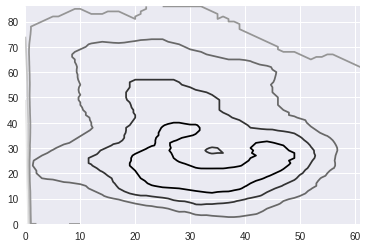

In [4]:
plt.contour(vht)

In [5]:
## Variogram

In [6]:
import random

svg = []
for i in range(100):
    x = random.randint(1,x_len)-1
    y = random.randint(1,y_len)-1
    v = np.array([x,y])
    a = vht[x,y]
    for j in range(100):
        x2 = random.randint(1,x_len)-1
        y2 = random.randint(1,y_len)-1
        v2 = np.array([x2,y2])
        a2 = vht[x2,y2]
        vd = v2 - v
        h = np.dot(vd,vd)
        ad = a2 - a
        svg.append([x,y,x2,y2,a,a2,h,np.sqrt(h),ad,ad*ad])
                

In [7]:
len(svg)

10000

In [8]:
dfSamples = pd.DataFrame(svg,columns=['x1','y1','x2','y2','a1','a2','distsq','dist','deviate','dsq'])
dfSamples['distance'] = dfSamples['dist']
dfSamples['Unit'] = 1

In [9]:
dfSamples[:6]

,x1,y1,x2,y2,a1,a2,distsq,dist,deviate,dsq,distance,Unit
0,25,45,30,50,181,168,50,7.071068,-13,169,7.071068,1
1,25,45,26,55,181,134,101,10.049876,-47,2209,10.049876,1
2,25,45,40,50,181,129,250,15.811388,-52,2704,15.811388,1
3,25,45,44,4,181,114,2042,45.188494,-67,4489,45.188494,1
4,25,45,56,27,181,151,1285,35.846897,-30,900,35.846897,1
5,25,45,51,49,181,119,692,26.305893,-62,3844,26.305893,1


In [10]:
xBins = pd.cut(dfSamples['dist'],bins=40)

In [11]:
binnedVar = dfSamples.groupby(xBins).agg({'dsq':np.mean,'Unit':np.sum,'distance':np.mean})
bVar = binnedVar.reset_index()
bVar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 4 columns):
dist        40 non-null category
dsq         40 non-null float64
Unit        40 non-null int64
distance    40 non-null float64
dtypes: category(1), float64(2), int64(1)
memory usage: 1.4 KB


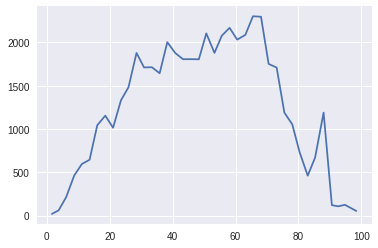

In [12]:
plt.plot(bVar['distance'],bVar['dsq'])


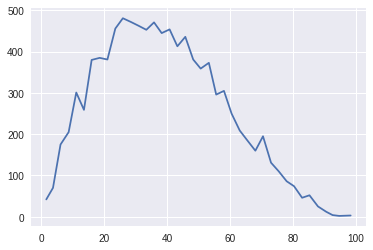

In [13]:
plt.plot(bVar['distance'],bVar['Unit'])

## Long distance variation has limited statistics due to the cut-off of the grid

In [14]:
N = 25
distances = bVar['distance'][:N]
variances = bVar['dsq'][:N]

bVar.head()

,dist,dsq,Unit,distance
0,"(-0.099, 2.476]",19.952381,42,1.646398
1,"(2.476, 4.952]",61.114286,70,3.774099
2,"(4.952, 7.428]",213.051429,175,6.169011
3,"(7.428, 9.905]",464.975610,205,8.748902
4,"(9.905, 12.381]",596.299003,301,11.172401


In [15]:
def variogram(d,a,b):
    return a * (np.tanh(d/b))

def vg_func(a,b):
    def this_variogram(d):
        return variogram(d,a=a,b=b)
    return this_variogram

In [16]:
tFunc = vg_func(2100,32)

def gen_plot(f):
    vdf = pd.DataFrame({'XVals':distances,'YVars':variances})
    vdf['YVals'] = vdf['XVals'].apply(f)
    return vdf

,XVals,YVars,YVals
count,25.000000,25.000000,25.000000
mean,30.967469,1381.491679,1371.735565
std,18.171648,685.603535,597.267132
min,1.646398,19.952381,107.949638
25%,16.062018,1014.398950,973.643930
50%,30.918470,1711.563715,1568.764293
75%,45.830350,1878.658898,1873.444106
max,60.536275,2168.531148,2006.605281


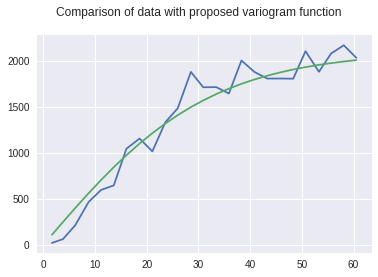

In [17]:
p = gen_plot(tFunc)
plt.plot(p['XVals'],p['YVars'])
plt.plot(p['XVals'],p['YVals'])
plt.suptitle("Comparison of data with proposed variogram function")
p.describe()

In [18]:
from scipy.optimize import curve_fit

In [19]:
cf = curve_fit(variogram,xdata=p['XVals'],ydata=p['YVars'])
a = cf[0][0]
b = cf[0][1]
print(cf)

(array([ 2213.70318279,    34.10632722]), array([[ 10418.31099653,    301.76854692],
       [   301.76854692,     10.51605843]]))


,XVals,YVars,YVals
count,25.000000,25.000000,25.000000
mean,30.967469,1381.491679,1401.942401
std,18.171648,685.603535,625.005381
min,1.646398,19.952381,106.778085
25%,16.062018,1014.398950,971.722993
50%,30.918470,1711.563715,1592.678542
75%,45.830350,1878.658898,1931.610583
max,60.536275,2168.531148,2090.061295


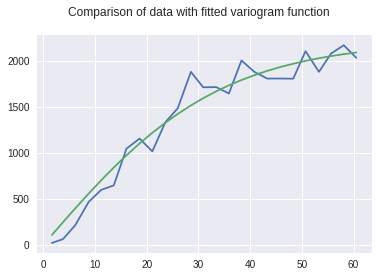

In [20]:
fittedVariogram = vg_func(a,b)

p = gen_plot(fittedVariogram)
plt.plot(p['XVals'],p['YVars'])
plt.plot(p['XVals'],p['YVals'])
plt.suptitle("Comparison of data with fitted variogram function")
p.describe()

In [21]:
def fit_at_N(N):
    distances = bVar['distance'][:N]
    variances = bVar['dsq'][:N]
    cf = curve_fit(variogram,xdata=distances,ydata=variances)
    a = cf[0][0]
    b = cf[0][1]
    return (a,b)

In [22]:
fits = []
for n in range(15,38):
    a, b =fit_at_N(n)
    fits.append([n,a,b])
dfFits = pd.DataFrame(fits,columns=["N","A","B"])

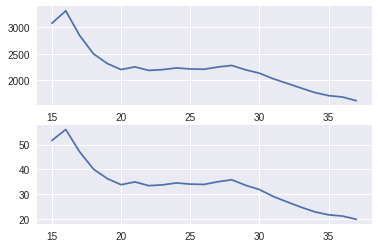

In [23]:
fig, axes = plt.subplots(nrows=2)

axes[0].plot(dfFits['N'],dfFits['A'])
axes[1].plot(dfFits['N'],dfFits['B'])


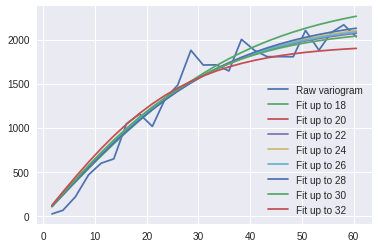

In [24]:
plt.plot(distances, variances, label="Raw variogram")

for N in range(18,33,2):
    row = dfFits[dfFits['N']==N]
    a = row['A']
    b = row['B']
    fittedVariogram = vg_func(a,b)

    p = gen_plot(fittedVariogram)
    plt.plot(p['XVals'],p['YVals'],label="Fit up to %i"%N)

plt.legend()

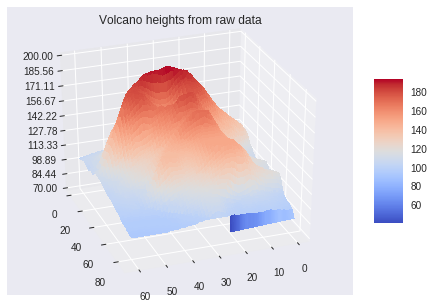

In [25]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

## Matplotlib Sample Code using 2D arrays via meshgrid
X, Y = np.meshgrid(x_grid,y_grid)

Z = np.sqrt(vht * vht).T

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_surface(Y, X, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_zlim(70, 200.0)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.view_init(30,70)

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Volcano heights from raw data')
plt.show()